In [1]:
# Imports using Sklearn make shortcut functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Imports
import os
from google.cloud import bigquery

In [2]:
# Environment variables
gcp_project_id = os.environ['GCP_PROJECT']
gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']
bq_source_dataset = os.environ['BQ_SOURCE_DATASET']
bq_cleaned_dataset = os.environ['BQ_CLEANED_DATASET']

In [3]:
# Import data from BQ and set data to X
# Initialize a BigQuery client using the service account JSON file
bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# Setting the table we want from the source dataset
select_table = 'cleaned_full_polls_combined_national_results_2004_2019'

# SQL query for querying Big Query and fetching entire table
query = f"""
    SELECT *
    FROM `{gcp_project_id}.{bq_cleaned_dataset}.{select_table}`
"""

In [4]:
# Use BQ client to create DF from the selected table
data = bq_client.query(query).to_dataframe()

/Users/nieksonneveld/.pyenv/versions/3.10.6/envs/election_predictor/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
# Replace any found NaN values with 0
data.replace(np.nan, 0, inplace=True)

# Add a field 'poll length' that shows number of days the poll was held for
data['poll_length'] = pd.to_datetime(data.enddate) - pd.to_datetime(data.startdate)
data['poll_length'] = data['poll_length'].dt.days

# Divide forecasts by 100 to create values between 0-1
for column in ['BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC']:
    data[column] = data[column] / 100

    # Divide actuals by 100 to create values between 0-1
for column in ['BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'NAT_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE']:
    data[column] = data[column] / 100

data.sort_values('enddate', inplace=True)

data.reset_index(inplace=True)

In [8]:
# Load Trends csvs from raw_data folder
trends1 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_CON_LIB_GRE_BRX_Trends_2004_now.csv')
trends2 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_PLC_SNP_UKI_NAT_Trends_2004_now.csv')

In [9]:
# Drop duplicate Labour column
trends2.drop(columns='Labour Party: (United Kingdom)',inplace=True)

In [10]:
# Join two trends datasets on 'Month'
trends_merged = pd.merge(trends1,trends2,how='left',on='Month')

In [11]:
trends_merged['Month'] = pd.to_datetime(trends_merged['Month'])

In [12]:
# Replace <1 values with 0.5 value
trends_merged.replace('<1', 0.5,inplace=True)

In [13]:
# Converting objects (pd.Series) to int dtypes
trends_merged = trends_merged.astype({'Green Party: (United Kingdom)':'int','Reform UK: (United Kingdom)':'int',\
    'Plaid Cymru: (United Kingdom)':'int','Scottish National Party: (United Kingdom)':'int',\
        'UK Independence Party: (United Kingdom)':'int','British National Party: (United Kingdom)':'int'})

In [14]:
# Rename columns to align them more easily with _FC and _ACT columns
trends_merged.rename(columns={'Labour Party: (United Kingdom)': 'LAB_trends',
        'Conservative Party: (United Kingdom)': 'CON_trends',
        'Liberal Democrats: (United Kingdom)': 'LIB_trends',
        'Green Party: (United Kingdom)': 'GRE_trends',
        'Reform UK: (United Kingdom)': 'BRX_trends',
        'Plaid Cymru: (United Kingdom)': 'PLC_trends',
        'Scottish National Party: (United Kingdom)': 'SNP_trends',
        'UK Independence Party: (United Kingdom)': 'UKI_trends',
        'British National Party: (United Kingdom)': 'NAT_trends'}
        ,inplace=True)

In [15]:
trends_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/national_google_trends_master.csv')

In [16]:
# Loading ONS csv files
ons_gdp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_gdp_2004_2024.csv')
ons_inf = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_inflation_2004_2024.csv')
ons_emp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_unemployment_2004_2024.csv')

In [17]:
# Replacing spaces with - for GDP df
ons_gdp.Quarter = ons_gdp.Quarter.str.replace(' ', '-')

# Turning quarters into months for GDP df
ons_gdp.Quarter = pd.PeriodIndex(ons_gdp.Quarter, freq='Q').to_timestamp()

# Fill missing months and impute with quarterly values per month for GDP df
ons_gdp = ons_gdp.set_index('Quarter').resample('MS').ffill()
ons_gdp.index.names = ['Month']

In [18]:
# Convert months into pd.DateTime and set as index
ons_inf.Month = pd.to_datetime(ons_inf.Month)
ons_inf = ons_inf.set_index('Month')

ons_emp.Month = pd.to_datetime(ons_emp.Month)
ons_emp = ons_emp.set_index('Month')

/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_17900/3454880804.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_inf.Month = pd.to_datetime(ons_inf.Month)
/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_17900/3454880804.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_emp.Month = pd.to_datetime(ons_emp.Month)


In [19]:
# Merging GDP, Inflation and Unemployment dfs into ons_merged
ons_merged = pd.merge(ons_gdp,pd.merge(ons_inf,ons_emp,how='left',on='Month'),how='outer',on='Month')

# Filling NaNs with previous value of column
ons_merged = ons_merged.ffill()

In [20]:
ons_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_economic_data_master.csv')

In [21]:
ons_merged.head()

,GDP,Inflation,Unemployment
Month,,,
2004-01-01,322790.0,1.5,4.8
2004-02-01,322790.0,1.4,4.8
2004-03-01,322790.0,1.2,4.8
2004-04-01,329664.0,1.1,4.8
2004-05-01,329664.0,1.4,4.8


In [22]:
# Create poll enddate field with YYYY-MM format, so we can join with Trends data
data['enddate_year_month'] = pd.to_datetime(data['enddate']).dt.to_period('M')

In [23]:
# Convert Period datatype to str and then to datetime64
data.enddate_year_month = pd.to_datetime(data.enddate_year_month.astype('str'))

In [24]:
# Merge data with trends data, to get a df with polls, election results and trends
data_trends = pd.merge(data,trends_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [25]:
# Merge data with ONS data, to get a df with polls, election results, trends and ONS data
data_trends_ons = pd.merge(data_trends,ons_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [26]:
# Scale trends columns by diving by 100
for column in ['LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends']:
    data_trends_ons[column] = data_trends_ons[column] / 100

In [27]:
# Drop columns we don't need
data_trends_ons = data_trends_ons.drop(columns=['startdate', 'enddate', 'pollster'])

In [28]:
data_trends_ons.columns

Index(['index', 'samplesize', 'rating', 'next_elec_date', 'days_to_elec',
       'BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC',
       'PLC_FC', 'SNP_FC', 'UKI_FC', 'NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE', 'poll_length', 'enddate_year_month', 'Month',
       'LAB_trends', 'CON_trends', 'LIB_trends', 'GRE_trends', 'BRX_trends',
       'PLC_trends', 'SNP_trends', 'UKI_trends', 'NAT_trends', 'GDP',
       'Inflation', 'Unemployment'],
      dtype='object')

In [29]:
from datetime import datetime
# Split data up to 2017 election (TRAIN) and all data related to 2019 election (TEST)
data_trends_ons['next_elec_date'] = data_trends_ons['next_elec_date'].astype("datetime64[ns]")
data_train = data_trends_ons[data_trends_ons['next_elec_date'] < datetime.strptime('2019-12-12', '%Y-%m-%d')]
data_test = data_trends_ons[data_trends_ons['next_elec_date'] == datetime.strptime('2019-12-12', '%Y-%m-%d')]

<Axes: >

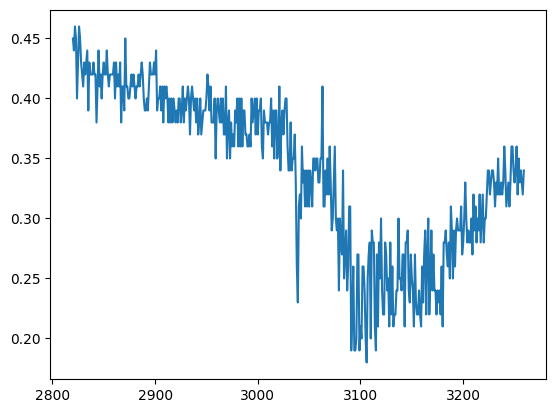

In [33]:
data_test.LAB_FC.plot()

In [34]:
# Handle numerical transformer
num_columns_selector = ['samplesize', 'days_to_elec', 'poll_length','GDP','Inflation','Unemployment']
num_transformer = MinMaxScaler()

In [35]:
# Handle categorical transformer
cat_columns_selector = ['rating']
cat_transformer = make_pipeline(OrdinalEncoder(categories = [['F','D-','D','D+','C-','B','B+','A-']]),MinMaxScaler())

In [36]:
# Build the preprocessing pipeline
preproc_pipeline = make_column_transformer(
    (num_transformer, num_columns_selector),
    (cat_transformer, cat_columns_selector),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [37]:
# Fit transform preprocessing pipeline to data_train
data_train_processed = preproc_pipeline.fit_transform(data_train)

# Transform preprocessing pipeline to data_test
data_test_processed = preproc_pipeline.transform(data_test)

In [38]:
# Check feature names make sense for data_train
data_train_processed = pd.DataFrame(
    data_train_processed, columns=preproc_pipeline.get_feature_names_out()
)

# Check feature names make sense for data_test
data_test_processed = pd.DataFrame(
    data_test_processed, columns=preproc_pipeline.get_feature_names_out()
)

In [39]:
data_train_processed.columns

Index(['samplesize', 'days_to_elec', 'poll_length', 'GDP', 'Inflation',
       'Unemployment', 'rating', 'index', 'next_elec_date', 'BRX_FC', 'CON_FC',
       'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC',
       'UKI_FC', 'NAT_ACT', 'BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT',
       'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE',
       'enddate_year_month', 'Month', 'LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends'],
      dtype='object')

In [40]:
# Define our X by dropping irrelevant and y columns

X_train = data_train_processed.drop(columns=['index','next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE','enddate_year_month','Month'])

X_test = data_test_processed.drop(columns=['index','next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE','enddate_year_month','Month'])

In [41]:
X_train.columns

Index(['samplesize', 'days_to_elec', 'poll_length', 'GDP', 'Inflation',
       'Unemployment', 'rating', 'BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC',
       'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC',
       'LAB_trends', 'CON_trends', 'LIB_trends', 'GRE_trends', 'BRX_trends',
       'PLC_trends', 'SNP_trends', 'UKI_trends', 'NAT_trends'],
      dtype='object')

In [42]:
# Build our target matrix, retaining each party share vote columns only
y_train = data_train_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

# Build our target matrix, retaining each party share vote columns only
y_test = data_test_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

In [43]:
# #TODO – refactor the below into a function > model instantiation, fitting, scoring, etc.
# # Handle target extraction for test and train sets respectively
# #TODO Kwarg > defaults to either cross val or prediction
# y_train_LAB = y_train['LAB_ACT']
# y_train_CON = y_train['CON_ACT']
# y_train_LIB = y_train['LIB_ACT']
# y_train_GRE = y_train['GRE_ACT']
# y_train_BRX = y_train['BRX_ACT']
# y_train_NAT = y_train['NAT_ACT']
# y_train_SNP = y_train['SNP_ACT']
# y_train_UKI = y_train['UKI_ACT']
# y_train_PLC = y_train['PLC_ACT']
# y_train_OTH = y_train['OTH_PERCENTAGE']

# y_test_LAB = y_test['LAB_ACT']
# y_test_CON = y_test['CON_ACT']
# y_test_LIB = y_test['LIB_ACT']
# y_test_GRE = y_test['GRE_ACT']
# y_test_BRX = y_test['BRX_ACT']
# y_test_NAT = y_test['NAT_ACT']
# y_test_SNP = y_test['SNP_ACT']
# y_test_UKI = y_test['UKI_ACT']
# y_test_PLC = y_test['PLC_ACT']
# y_test_OTH = y_test['OTH_PERCENTAGE']

In [44]:
# # Instantiate the model for each party
# model_LAB = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_CON = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_LIB = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_GRE = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_BRX = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_NAT = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_SNP = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_UKI = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_PLC = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)
# model_OTH = XGBRegressor(learning_rate=0.3, n_estimators=300,
#                                      max_depth=3, subsample=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      enable_categorical=True)

In [45]:
# # Handle model training
# X_train_matrix = np.array(X_train)

# model_LAB.fit(X_train_matrix, y_train_LAB)
# model_CON.fit(X_train_matrix, y_train_CON)
# model_LIB.fit(X_train_matrix, y_train_LIB)
# model_GRE.fit(X_train_matrix, y_train_GRE)
# model_BRX.fit(X_train_matrix, y_train_BRX)
# model_NAT.fit(X_train_matrix, y_train_NAT)
# model_SNP.fit(X_train_matrix, y_train_SNP)
# model_UKI.fit(X_train_matrix, y_train_UKI)
# model_PLC.fit(X_train_matrix, y_train_PLC)
# model_OTH.fit(X_train_matrix, y_train_OTH)

In [46]:
# # Evaluate model performance with cross validation
# X_test_matrix = np.array(X_test)

# y_pred_LAB = model_LAB.predict(X_test_matrix)
# y_pred_CON = model_CON.predict(X_test_matrix)
# y_pred_LIB = model_LIB.predict(X_test_matrix)
# y_pred_GRE = model_GRE.predict(X_test_matrix)
# y_pred_BRX = model_BRX.predict(X_test_matrix)
# y_pred_NAT = model_NAT.predict(X_test_matrix)
# y_pred_SNP = model_SNP.predict(X_test_matrix)
# y_pred_UKI = model_UKI.predict(X_test_matrix)
# y_pred_PLC = model_PLC.predict(X_test_matrix)
# y_pred_OTH = model_OTH.predict(X_test_matrix)

In [47]:
# print(f"2019 prediction for LAB: {y_pred_LAB.mean()}")
# print(f"2019 prediction for CON: {y_pred_CON.mean()}")
# print(f"2019 prediction for LIB: {y_pred_LIB.mean()}")
# print(f"2019 prediction for GRE: {y_pred_GRE.mean()}")
# print(f"2019 prediction for BRX: {y_pred_BRX.mean()}")
# print(f"2019 prediction for NAT: {y_pred_NAT.mean()}")
# print(f"2019 prediction for SNP: {y_pred_SNP.mean()}")
# print(f"2019 prediction for UKI: {y_pred_UKI.mean()}")
# print(f"2019 prediction for PLC: {y_pred_PLC.mean()}")
# print(f"2019 prediction for OTH: {y_pred_OTH.mean()}")

In [48]:
# print(f"2019 prediction for LAB: {y_pred_LAB[-25:-1].mean()}")
# print(f"2019 prediction for CON: {y_pred_CON[-25:-1].mean()}")
# print(f"2019 prediction for LIB: {y_pred_LIB[-25:-1].mean()}")
# print(f"2019 prediction for GRE: {y_pred_GRE[-25:-1].mean()}")
# print(f"2019 prediction for BRX: {y_pred_BRX[-25:-1].mean()}")
# print(f"2019 prediction for NAT: {y_pred_NAT[-25:-1].mean()}")
# print(f"2019 prediction for SNP: {y_pred_SNP[-25:-1].mean()}")
# print(f"2019 prediction for UKI: {y_pred_UKI[-25:-1].mean()}")
# print(f"2019 prediction for PLC: {y_pred_PLC[-25:-1].mean()}")
# print(f"2019 prediction for OTH: {y_pred_OTH[-25:-1].mean()}")

In [49]:
plt.scatter(y=y_pred_LAB,x=data_test['days_to_elec'])
plt.scatter(y=y_test_LAB,x=data_test['days_to_elec'])
plt.scatter(y=data_test['LAB_FC'],x=data_test['days_to_elec'])

NameError: name 'y_pred_LAB' is not defined

In [50]:
plt.scatter(y=y_train_LAB,x=data_train['days_to_elec'])
plt.scatter(y=data_train['LAB_FC'],x=data_train['days_to_elec'])

NameError: name 'y_train_LAB' is not defined

### Code below is to test neural network

In [45]:
# # Converting data to floats for NN
# X_train_matrix_nn = X_train_matrix.astype('float')
# X_test_matrix_nn = X_test_matrix.astype('float')


# y_train_LAB_nn = y_train_LAB.astype('float')

# y_test_LAB_nn = y_test_LAB.astype('float')

In [46]:
# # Initialising Dense NN model

# def initialize_model():

#     model = models.Sequential()

#     model.add(layers.Dense(20, input_dim=X_train_matrix.shape[1], activation='relu'))  # /!\ Input size is equal to number of features
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(1, activation='linear')) # /!\ Trying to predict continuous variable (regression task)

#     return model

In [47]:
# # Compile model using adam optimiser and MSE as loss function

# def compile_model(model, optimizer_name):
#     model.compile(loss='mse', optimizer=optimizer_name, metrics=['mse'])
#     return model

In [48]:
# model = initialize_model()
# compile_model(model,'adam')
# es = EarlyStopping(patience=5, restore_best_weights=True)

# history = model.fit(X_train_matrix_nn, y_train_LAB_nn,
#           batch_size=16,
#           epochs=1000,
#           callbacks=[es])

# results = model.evaluate(X_test_matrix_nn,y_test_LAB_nn)

Epoch 1/1000


/Users/nieksonneveld/.pyenv/versions/3.10.6/envs/election_predictor/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - loss: 0.0132 - mse: 0.0132 
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 9.2364e-04 - mse: 9.2364e-04
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 4.3673e-04 - mse: 4.3673e-04
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 2.9243e-04 - mse: 2.9243e-04
Epoch 5/1000
  1/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0255e-04 - mse: 3.0255e-04

/Users/nieksonneveld/.pyenv/versions/3.10.6/envs/election_predictor/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mse
  current = self.get_monitor_value(logs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 2.4593e-04 - mse: 2.4593e-04
Epoch 6/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 1.8861e-04 - mse: 1.8861e-04
Epoch 7/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 1.8978e-04 - mse: 1.8978e-04
Epoch 8/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 1.2377e-04 - mse: 1.2377e-04
Epoch 9/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 1.0563e-04 - mse: 1.0563e-04
Epoch 10/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.1195e-04 - mse: 1.1195e-04
Epoch 11/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.1489e-04 - mse: 1.1489e-04
Epoch 12/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.3175e-04 - mse: 1.3175e-04
Epoch 13/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 6.5506e-05 - mse: 6.5506e-05
Epoch 14/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 1.0178e-04 - mse: 1.0178e-04
Epoch 15/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 6.7960e-05 - 

In [50]:
# y_pred_LAB_nn = model.predict(X_test_matrix_nn)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [51]:
# print(y_pred_LAB_nn[-1])

[0.417369]


#### Investigating features for collinearity and feature permutation

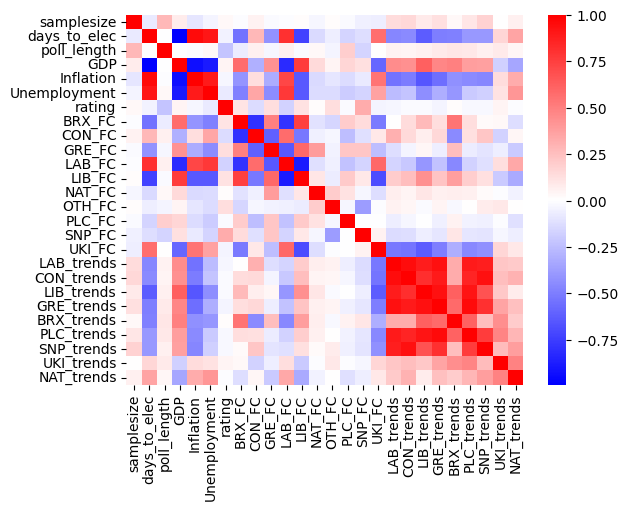

In [51]:
# Heatmap of pairwise correlations
correlation_matrix = X_test.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [52]:
# Convert the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Rename the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [53]:
# Compute the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showe the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(30)

,feature_1,feature_2,correlation,absolute_correlation
29,days_to_elec,GDP,-0.992023,0.992023
79,GDP,days_to_elec,-0.992023,0.992023
30,days_to_elec,Inflation,0.958164,0.958164
105,Inflation,days_to_elec,0.958164,0.958164
592,PLC_trends,GRE_trends,0.955735,0.955735
542,GRE_trends,PLC_trends,0.955735,0.955735
485,CON_trends,LAB_trends,0.952261,0.952261
460,LAB_trends,CON_trends,0.952261,0.952261
82,GDP,Inflation,-0.937016,0.937016
107,Inflation,GDP,-0.937016,0.937016
